# This notebook implements Deep learning techniques for a particle-in-halo classification framework. 

Reference with random forest: [ChJazhiel notebook](https://github.com/ChJazhiel/ML_ICF/blob/master/RF_Particles_z23.ipynb)

In [1]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import AutoMinorLocator
import pandas as pd

from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels
from sklearn.model_selection import cross_val_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import f1_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import f1_score
from sklearn.feature_selection import SelectFromModel
from sklearn.feature_selection import f_classif
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import mutual_info_classif
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import RepeatedStratifiedKFold

import tensorflow as tf
from tensorflow.keras.layers import Dense, Flatten, Conv2D
from tensorflow.keras import Model
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras import optimizers
from tensorflow.keras import losses

%matplotlib inline

# workdirectory = '/home/jazhiel/ML_Notebooks/Cosmology_ML/'
workdirectory = ''

2022-05-10 14:48:43.134518: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-05-10 14:48:43.134565: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


## Import our dataset 

In [2]:
data_dict = np.load(workdirectory + 'OUTFILE1M.npz') #np.load('/path/to/nbody/outfile.npz')
test_flags  = data_dict['test_flags'] ## not important
test_hosts  = data_dict['test_hosts'] ### somewhat relevant
test_mass   = data_dict['test_mass'] ## important
test_labels = data_dict['test_labels'] ## important
test_input  = data_dict['test_input'] ## very important
#test_snid   = dict_data['test_snid']
#test_labels = dict_data['test_labels']
print(test_mass) ## Here I want to check how is the halo mass matrix composed of, the -1 means the halo 
#is not in our range of 10^12-10^13 M_sun
print(np.sum(test_labels)) ## Here I want to check how many label "1" do we have

[-1.00000000e+00  2.72242898e+13  1.13894322e+13 ... -1.00000000e+00
 -1.00000000e+00 -1.00000000e+00]
289964


## Data preprocessing

In [3]:
### here we create or 10 vector dataset, I wonder if by adding some other information the classification will be better
### adding mass is not helpful, the classifier is perfect in that regard
dr1 = pd.DataFrame(test_input[0], columns = ['dr1'])
dr2 = pd.DataFrame(test_input[1], columns = ['dr2'])
dr3 = pd.DataFrame(test_input[2], columns = ['dr3'])
dr4 = pd.DataFrame(test_input[3], columns = ['dr4'])
dr5 = pd.DataFrame(test_input[4], columns = ['dr5'])
dr6 = pd.DataFrame(test_input[5], columns = ['dr6'])
dr7 = pd.DataFrame(test_input[6], columns = ['dr7'])
dr8 = pd.DataFrame(test_input[7], columns = ['dr8'])
dr9 = pd.DataFrame(test_input[8], columns = ['dr9'])
dr10 = pd.DataFrame(test_input[9], columns = ['dr10'])
#mass = pd.DataFrame(test_mass, columns = ['Halo_Mass'])
lbl = pd.DataFrame(test_labels, columns =['labels'])

## Select all features and create dataframe

In [4]:
df = pd.concat([dr1, dr2, dr3, dr4, dr5, dr6, dr7, dr8, dr9, dr10, lbl], axis=1, ignore_index=False, sort=False)
df

,dr1,dr2,dr3,dr4,dr5,dr6,dr7,dr8,dr9,dr10,labels
0,-0.209889,-0.187730,-0.169542,-0.155964,-0.100744,-0.049741,-0.011099,-0.010984,-0.002834,0.024089,0
1,0.364046,0.430008,0.453121,0.450021,0.374578,0.309706,0.240559,0.190503,0.174401,0.176335,1
2,0.311775,0.254511,0.227109,0.215286,0.148460,0.112097,0.090454,0.058546,0.035873,0.043613,1
3,0.033877,0.051836,0.065151,0.073930,0.100935,0.100271,0.094132,0.080007,0.059981,0.032160,0
4,-0.355428,-0.330448,-0.306125,-0.291701,-0.253399,-0.215256,-0.163749,-0.124680,-0.080408,-0.051999,0
...,...,...,...,...,...,...,...,...,...,...,...
999995,0.022223,0.034349,0.046298,0.047812,0.027945,0.018082,0.012005,0.015623,0.028762,0.036779,0
999996,-0.178963,-0.188312,-0.189045,-0.187326,-0.182576,-0.170714,-0.155041,-0.143078,-0.136640,-0.120222,0
999997,-0.164632,-0.113120,-0.076089,-0.061724,0.009549,0.039809,0.057906,0.041327,0.010610,-0.020231,0
999998,-0.039698,0.063765,0.118363,0.140928,0.152761,0.125845,0.114529,0.113929,0.107155,0.098008,0


## Here we select a dataframe consisting of evenly separated labels

(I'm not sure if selecting all particles will impact in a different result)


In [5]:
## Sorting out the labels consisting in label '0' and label '1'
## Then we sample them in order to not selecting them in a specific range or shape

df_0 = df.sort_values('labels').head(710036).sample(289000)
df_1 = df.sort_values('labels').tail(289964).sample(289000) 
df_1.labels.sum()
df_r = pd.concat([df_0, df_1])
#df_scaled = scaler.fit_transform(df_r.drop(['labels'], axis = 1))  
#df_copy1 = pd.DataFrame(df_scaled, columns=['dr1', 'dr2', 'dr3', 'dr4', 'dr5', 'dr6', 'dr7', 'dr8', 'dr9', 'dr10'])

suffle = 
shuffle_df = df_r.values
shuffle_df

,dr1,dr2,dr3,dr4,dr5,dr6,dr7,dr8,dr9,dr10,labels
873355,0.339122,0.268589,0.250099,0.245457,0.209636,0.194077,0.196929,0.202085,0.197608,0.175460,1
938605,-0.006768,-0.032494,-0.041201,-0.044158,-0.041670,-0.034938,-0.042934,-0.059431,-0.070397,-0.055636,0
981609,0.589905,0.533546,0.478454,0.454234,0.343689,0.305892,0.257054,0.222879,0.183936,0.129742,0
603119,0.556042,0.423658,0.402281,0.388919,0.334914,0.314119,0.262381,0.248686,0.266294,0.232785,1
489938,0.265110,0.117971,0.064435,0.049822,0.001843,-0.022175,-0.052999,-0.073641,-0.071082,-0.066284,0
...,...,...,...,...,...,...,...,...,...,...,...
382305,-0.069678,-0.081794,-0.086887,-0.088343,-0.043663,0.000341,0.074103,0.146201,0.184594,0.162823,1
468537,0.346548,0.222592,0.182835,0.168199,0.097503,0.077273,0.069606,0.079294,0.083898,0.076114,0
308500,0.534246,0.484101,0.419624,0.391286,0.323944,0.270528,0.238909,0.214633,0.196696,0.170755,1
744815,0.313538,0.302703,0.274471,0.260597,0.191736,0.138454,0.090016,0.045224,-0.007591,-0.033271,1


## define a size for our traning dataset 

I think that for 500k + particles we can divide into train, test and validation datasets

In [6]:
# Define a size for your train set 
train_size = int(0.8 * len(df_r))

# Split your dataset 
train_set = shuffle_df[:train_size]
test_set = shuffle_df[train_size:]

train_set

,dr1,dr2,dr3,dr4,dr5,dr6,dr7,dr8,dr9,dr10,labels
873355,0.339122,0.268589,0.250099,0.245457,0.209636,0.194077,0.196929,0.202085,0.197608,0.175460,1
938605,-0.006768,-0.032494,-0.041201,-0.044158,-0.041670,-0.034938,-0.042934,-0.059431,-0.070397,-0.055636,0
981609,0.589905,0.533546,0.478454,0.454234,0.343689,0.305892,0.257054,0.222879,0.183936,0.129742,0
603119,0.556042,0.423658,0.402281,0.388919,0.334914,0.314119,0.262381,0.248686,0.266294,0.232785,1
489938,0.265110,0.117971,0.064435,0.049822,0.001843,-0.022175,-0.052999,-0.073641,-0.071082,-0.066284,0
...,...,...,...,...,...,...,...,...,...,...,...
150118,-0.272889,-0.188121,-0.151773,-0.141120,-0.096308,-0.070185,-0.040450,0.006147,0.037035,0.030528,0
479183,-0.135092,-0.158606,-0.165807,-0.166624,-0.135978,-0.103245,-0.065305,-0.031907,-0.009468,0.021500,0
671981,-0.417997,-0.358565,-0.325448,-0.313862,-0.272948,-0.255050,-0.227393,-0.195574,-0.151699,-0.107099,0
128479,0.474379,0.346949,0.314508,0.309122,0.258790,0.220318,0.171846,0.133278,0.088569,0.046700,1


## Select data, X for attributes, y for labels

In [7]:
X = shuffle_df.drop(['labels'], axis = 1)
ylabels = shuffle_df.labels
#ymodel = shuffle_df.Model
#ymodel = copy1.Model
X_train = train_set.drop(['labels'], axis = 1)
X_test = test_set.drop(['labels'], axis= 1)
y_trainl = train_set.labels
y_testl = test_set.labels
#y_trainM = train_set.Model
#y_testM = test_set.Model
print(X_train.shape)

(462400, 10)


## For the Confusion matrix 


In [8]:
#### THIS CELL IS FOR CALCULATE THE CONFUSION MATRIX ####
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

np.set_printoptions(precision=2)

## Random forest with sklearn 

In [9]:
rf=RandomForestClassifier(n_estimators=100, max_depth=8, n_jobs=-1,
                          criterion = 'entropy', class_weight='balanced')

## n_jobs = -1 tells my computer to use all its cores, I have only 2, so it runs on 2 cores
#Train the model using the training sets y_pred=clf.predict(X_test)
rf.fit(X_train,y_trainl)

ypred = rf.predict(X_test)
#####

print('Traning and Testing on raw data, all features \n');
#### Model accuracy
print("Accuracy:", metrics.accuracy_score(y_testl, ypred))

for i, score_forest in enumerate(cross_val_score(rf, X, ylabels, cv = 3)):
    print('Random Forest accuracy for the %d score: %0.2f' % (i, score_forest))
score_forest=cross_val_score(rf, X, ylabels, cv=3)
#score_tree
cv_scores = []
print("Random Forest Accuracy: %0.2f (+/- %0.2f)" % (score_forest.mean(), score_forest.std() * 2 ))
cv_score = score_forest.mean()
cv_scores.append(cv_score)

### We perform a cross validation score to see how accurate our decision tree is by 
### splitting the dataset into 10 folds for training and testing

Traning and Testing on raw data, all features 

Accuracy: 0.7854325259515571
Random Forest accuracy for the 0 score: 0.78
Random Forest accuracy for the 1 score: 0.78
Random Forest accuracy for the 2 score: 0.78
Random Forest Accuracy: 0.78 (+/- 0.00)


## Perceptron with Keras

In [10]:
#para scikit-learn: (samples,features)
#test_input_T = test_input.T
#X_train, X_test, y_train, y_test = train_test_split(test_input_T,test_labels,test_size=0.25,random_state=None)

#ANN
test1_model = models.Sequential()
test1_model.add(layers.Dense(100,activation='selu',input_shape=(10,)))
test1_model.add(layers.Dense(100,activation='selu'))
test1_model.add(layers.Dense(100,activation='selu'))
#test1_model.add(layers.Dense(32,activation='relu'))
#test1_model.add(layers.Dense(10,activation='relu'))
test1_model.add(layers.Dense(1, activation='sigmoid'))

test1_model.compile(optimizer=optimizers.Adam(),#RMSprop(lr=0.001),
                    loss=losses.binary_crossentropy,
                    metrics=['accuracy'])


test1_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 100)               1100      
_________________________________________________________________
dense_1 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_2 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 101       
Total params: 21,401
Trainable params: 21,401
Non-trainable params: 0
_________________________________________________________________


2022-05-10 14:50:31.796640: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-05-10 14:50:31.796661: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-05-10 14:50:31.796676: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (isidro-pc): /proc/driver/nvidia/version does not exist
2022-05-10 14:50:31.796875: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [13]:
callbacks = [tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=50, restore_best_weights=True)]
test1_model_history = test1_model.fit(X_train,
                                      y_trainl,
                                      epochs=100,
                                      batch_size=512,
                                      validation_data=(X_test,y_testl),
                                      verbose=1, callbacks=callbacks)

Epoch 1/100
904/904 [==============================] - 1s 2ms/step - loss: 0.4588 - accuracy: 0.7825 - val_loss: 0.4555 - val_accuracy: 0.7843
Epoch 2/100
904/904 [==============================] - 1s 2ms/step - loss: 0.4587 - accuracy: 0.7825 - val_loss: 0.4558 - val_accuracy: 0.7841
Epoch 3/100
904/904 [==============================] - 1s 2ms/step - loss: 0.4587 - accuracy: 0.7825 - val_loss: 0.4559 - val_accuracy: 0.7845
Epoch 4/100
904/904 [==============================] - 1s 2ms/step - loss: 0.4587 - accuracy: 0.7826 - val_loss: 0.4566 - val_accuracy: 0.7836
Epoch 5/100
904/904 [==============================] - 1s 2ms/step - loss: 0.4585 - accuracy: 0.7826 - val_loss: 0.4568 - val_accuracy: 0.7837
Epoch 6/100
904/904 [==============================] - 1s 2ms/step - loss: 0.4584 - accuracy: 0.7827 - val_loss: 0.4556 - val_accuracy: 0.7841
Epoch 7/100
904/904 [==============================] - 1s 2ms/step - loss: 0.4584 - accuracy: 0.7826 - val_loss: 0.4567 - val_accuracy: 0.7837

Epoch 58/100
904/904 [==============================] - 1s 2ms/step - loss: 0.4570 - accuracy: 0.7831 - val_loss: 0.4549 - val_accuracy: 0.7839
Epoch 59/100
904/904 [==============================] - 1s 2ms/step - loss: 0.4569 - accuracy: 0.7836 - val_loss: 0.4552 - val_accuracy: 0.7842
Epoch 60/100
904/904 [==============================] - 1s 1ms/step - loss: 0.4568 - accuracy: 0.7833 - val_loss: 0.4551 - val_accuracy: 0.7842
Epoch 61/100
904/904 [==============================] - 1s 2ms/step - loss: 0.4570 - accuracy: 0.7835 - val_loss: 0.4540 - val_accuracy: 0.7846
Epoch 62/100
904/904 [==============================] - 1s 1ms/step - loss: 0.4570 - accuracy: 0.7832 - val_loss: 0.4543 - val_accuracy: 0.7843
Epoch 63/100
904/904 [==============================] - 1s 2ms/step - loss: 0.4569 - accuracy: 0.7832 - val_loss: 0.4541 - val_accuracy: 0.7843
Epoch 64/100
904/904 [==============================] - 1s 2ms/step - loss: 0.4568 - accuracy: 0.7831 - val_loss: 0.4542 - val_accuracy:

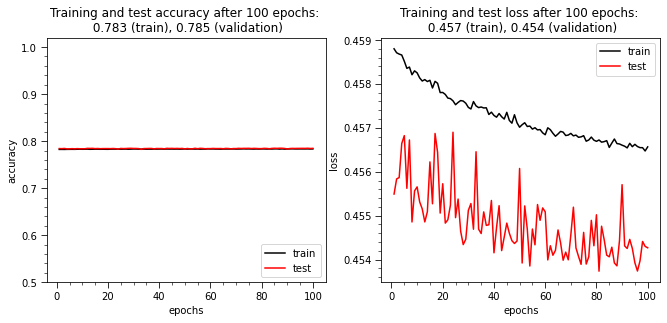

In [14]:
#plot
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(11,4.5))    

results_dict = test1_model_history.history
epochs = range(1,len(results_dict['accuracy'])+1)

#accuracy
acc_values = results_dict['accuracy']
val_acc_values = results_dict['val_accuracy']
    
axs[0].plot(epochs,acc_values,color='black',label='train',linewidth=1.5,linestyle='-')
axs[0].plot(epochs,val_acc_values,color='red',label='test',linewidth=1.5,linestyle='-')
axs[0].set_xlabel('epochs')
minorLocatorX = AutoMinorLocator()
axs[0].xaxis.set_minor_locator(minorLocatorX)
axs[0].set_ylabel('accuracy')
axs[0].set_ylim([0.5, 1.02])   
minorLocatorY = AutoMinorLocator()
axs[0].yaxis.set_minor_locator(minorLocatorY)
axs[0].tick_params(which='major', length=6)
axs[0].tick_params(which='minor', length=3, color='black')       
axs[0].legend(loc='lower right')
    
#loss
loss_values = results_dict['loss']
val_loss_values = results_dict['val_loss']
       
axs[1].plot(epochs,loss_values,color='black',label='train',linewidth=1.5,linestyle='-')
axs[1].plot(epochs,val_loss_values,color='red',label='test',linewidth=1.5,linestyle='-')
axs[1].set_xlabel('epochs')
minorLocatorX = AutoMinorLocator()
axs[1].xaxis.set_minor_locator(minorLocatorX)   
axs[1].set_ylabel('loss')
minorLocatorY = AutoMinorLocator()
axs[1].yaxis.set_minor_locator(minorLocatorY)
axs[1].tick_params(which='major', length=6)
axs[1].tick_params(which='minor', length=3, color='black')    
axs[1].legend(loc='upper right')

axs[0].set_title('Training and test accuracy after {} epochs: \n {:.3f} (train), {:.3f} (validation)'
                 .format(len(epochs),acc_values[-1],val_acc_values[-1]));

axs[1].set_title('Training and test loss after {} epochs: \n {:.3f} (train), {:.3f} (validation)'
                 .format(len(epochs),loss_values[-1],val_loss_values[-1]));